# Exploratory Data Analysis – Mercado Global del Café

## 1. Introducción
El café es uno de los productos agrícolas más comercializados a nivel mundial y constituye
una fuente de ingresos clave para numerosos países productores. Sin embargo, el mercado
global del café presenta fuertes diferencias entre países en términos de volumen de
producción y participación en el valor total generado.

El objetivo de este análisis exploratorio es estudiar la distribución de la producción de
café entre los países productores y evaluar si dicha distribución es homogénea o si, por
el contrario, existe una concentración significativa en un número reducido de países.

Para ello, se analizarán datos históricos de producción de café a nivel país, aplicando
técnicas de análisis exploratorio de datos (EDA) que permitan identificar patrones,
desigualdades y niveles de concentración en la producción global.

## 2. Hipótesis
H1: El valor total del café no se distribuye de forma homogénea entre los países productores.


In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [204]:
df_prod = pd.read_csv("src/data/Coffee_production.csv")

In [205]:

# 2) Normalizar nombres de columnas (evita errores por espacios)
df_prod.columns = df_prod.columns.str.strip()

# 3) Renombrar columnas clave 
df_prod = df_prod.rename(columns={
    "Country": "Country",
    "Coffee type": "Coffee type",
    "Total_production": "Total_production"
})

# 4) Identificar columnas que son años (ej: '1990/91', '1991/92', ...)
year_cols = [c for c in df_prod.columns if "/" in str(c) and str(c)[:4].isdigit()]

# 5) Pasar a formato largo
df_prod_long = df_prod.melt(
    id_vars=["Country", "Coffee type"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Production"
)

# 6) Limpiar Year: nos quedamos con el año inicial (1990/91 -> 1990)
df_prod_long["Year"] = df_prod_long["Year"].astype(str).str[:4].astype(int)

# 7) Asegurar Production como numérico
df_prod_long["Production"] = pd.to_numeric(df_prod_long["Production"], errors="coerce")

# 8) Eliminar nulos de producción (si los hay)
df_prod_long = df_prod_long.dropna(subset=["Production"])

# 9) (Opcional pero recomendado) Ordenar para lectura
df_prod_long = df_prod_long.sort_values(["Country", "Year"]).reset_index(drop=True)

# 10) Mostrar primeras filas 
print("\n--- DataFrame de Producción  ---\n")
display(df_prod_long.head())



--- DataFrame de Producción  ---



,Country,Coffee type,Year,Production
0,Angola,Robusta/Arabica,1990,3000000.0
1,Angola,Robusta/Arabica,1991,4740000.0
2,Angola,Robusta/Arabica,1992,4680000.0
3,Angola,Robusta/Arabica,1993,1980000.0
4,Angola,Robusta/Arabica,1994,4620000.0


Observamos que el dataset contiene información de producción anual de café por país,
expresada en miles de sacos, con un registro por país y año.


In [206]:
produccion_pais = (
    df_prod_long
    .groupby("Country")["Production"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

produccion_pais.head()


,Country,Production
0,Brazil,7.508298e+10
1,Viet Nam,2.880318e+10
2,Colombia,2.159862e+10
3,Indonesia,1.540488e+10
4,Ethiopia,8.669520e+09


### Top 10 Países Productores
#### El ranking de producción muestra que un número reducido de países concentra una parte significativa del volumen total de café producido

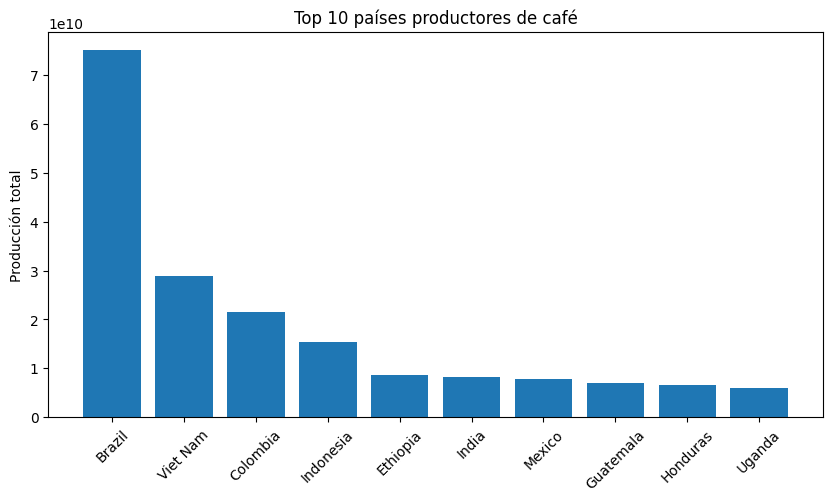

In [207]:
import matplotlib.pyplot as plt

top10 = produccion_pais.head(10)

plt.figure(figsize=(10,5))
plt.bar(top10["Country"], top10["Production"])
plt.xticks(rotation=45)
plt.title("Top 10 países productores de café")
plt.ylabel("Producción total")
plt.show()


### Distribución global de la producción
#### La distribución presenta una fuerte asimetría positiva, indicando que la mayoría de países produce volúmenes reducidos frente a unos pocos grandes productores.

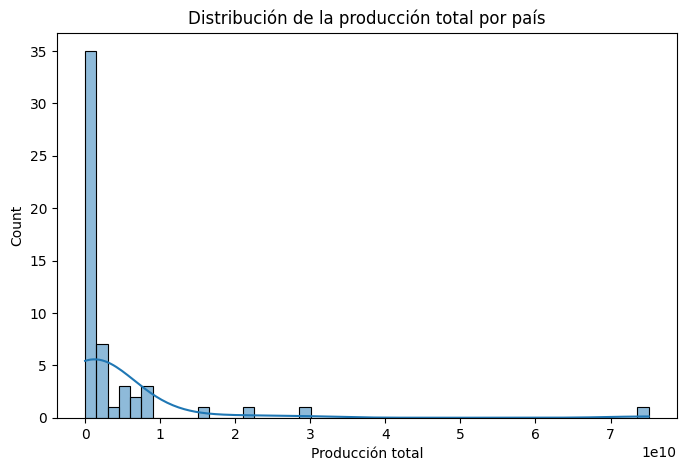

In [208]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(produccion_pais["Production"], bins=50, kde=True)
plt.title("Distribución de la producción total por país")
plt.xlabel("Producción total")
plt.show()


### Porcentaje acumulado (curva de concentración)
#### Se observa que un pequeño número de países concentra un porcentaje elevado de la producción total, lo que evidencia una distribución no homogénea.



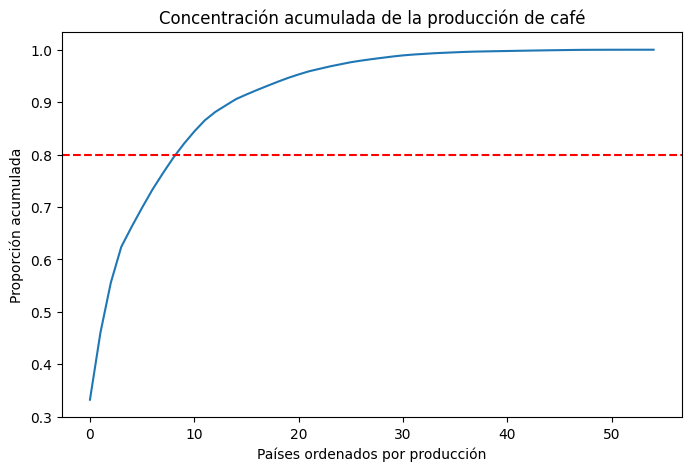

In [209]:
produccion_pais["share"] = (
    produccion_pais["Production"] / produccion_pais["Production"].sum()
)

produccion_pais["cum_share"] = produccion_pais["share"].cumsum()

plt.figure(figsize=(8,5))
plt.plot(produccion_pais["cum_share"].values)
plt.axhline(0.8, color="red", linestyle="--")
plt.title("Concentración acumulada de la producción de café")
plt.ylabel("Proporción acumulada")
plt.xlabel("Países ordenados por producción")
plt.show()


Esto significa que:  

Solo 5 países producen casi dos tercios del café del mundo,
y solo 10 países producen más del 80%.  
Los cinco principales países productores concentran aproximadamente el 63% de la producción total, confirmando una elevada concentración del mercado.


Top 5 países → ~66.3% de la producción mundial

Top 10 países → ~82.1% de la producción mundial

In [210]:
top5_share = produccion_pais.head(5)["share"].sum()
top10_share = produccion_pais.head(10)["share"].sum()

top5_share, top10_share


(np.float64(0.6625436873230279), np.float64(0.8206428232915065))

#### Coeficiente de variación
##### CV 2.71 → alta desigualdad  
CV < 0.5	Distribución bastante homogénea  
0.5 ≤ CV < 1	Dispersión moderada  
CV ≥ 1	Alta desigualdad / concentración  


In [211]:
# Calculamos el cv (coeficiente de Variación) mide cuanta desigualdad se reparte la produccion
cv = produccion_pais["Production"].std() / produccion_pais["Production"].mean()
cv


np.float64(2.7107128529813265)

El coeficiente de variación de la producción total por país presenta un valor elevado, lo que indica una alta dispersión relativa. Este resultado refuerza la existencia de una distribución desigual de la producción de café entre los países productores.